In [1]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from load_data import load_data_from_postgres, load_data_using_sqlalchemy
from prepare_data import clean_data

In [2]:
# Run the query
query = "SELECT * FROM xdr_data;"  # Replace with actual table name
df = load_data_using_sqlalchemy(query)
df_cleaned = clean_data(df)
if df is not None:
    print("Successfully loaded the data")
    display(df_cleaned.head())
else:
    print("Failed to load data.")

Successfully loaded the data


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,2019-04-04 12:01:00,770.0,2019-04-25 14:35:00,662.0,92261.223185,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,2019-04-09 13:04:00,235.0,2019-04-25 08:15:00,606.0,92261.223185,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,2019-04-09 17:42:00,1.0,2019-04-25 11:58:00,652.0,92261.223185,2.082015e+14,3.365762e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,2019-04-10 00:31:00,486.0,2019-04-25 07:36:00,171.0,92261.223185,2.082014e+14,3.365762e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,2019-04-12 20:10:00,565.0,2019-04-25 10:40:00,954.0,92261.223185,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


Task 4: Satisfaction Analysis

Task 4.1: Engagement and Experience Score Calculation


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Select engagement and experience features
engagement_features = ['Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)', 'Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)']
experience_features = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']

scaler = StandardScaler()
scaled_engagement = scaler.fit_transform(df_cleaned[engagement_features])
scaled_experience = scaler.fit_transform(df_cleaned[experience_features])


kmeans_engagement = KMeans(n_clusters=2, random_state=42)
df_cleaned['Engagement Cluster'] = kmeans_engagement.fit_predict(scaled_engagement)


kmeans_experience = KMeans(n_clusters=2, random_state=42)
df_cleaned['Experience Cluster'] = kmeans_experience.fit_predict(scaled_experience)


engagement_centers = kmeans_engagement.cluster_centers_
experience_centers = kmeans_experience.cluster_centers_

less_engaged_cluster = np.argmin(np.linalg.norm(engagement_centers, axis=1))
worst_experience_cluster = np.argmin(np.linalg.norm(experience_centers, axis=1))


In [4]:
from scipy.spatial.distance import cdist

df_cleaned['Engagement Score'] = cdist(scaled_engagement, [engagement_centers[less_engaged_cluster]], 'euclidean')


df_cleaned['Experience Score'] = cdist(scaled_experience, [experience_centers[worst_experience_cluster]], 'euclidean')


Task 4.2: Calculate Satisfaction Score

In [5]:

df_cleaned['Satisfaction Score'] = (df_cleaned['Engagement Score'] + df_cleaned['Experience Score']) / 2


top_10_satisfied_customers = df_cleaned.nlargest(10, 'Satisfaction Score')
print(top_10_satisfied_customers[['IMSI', 'Satisfaction Score']])


                IMSI  Satisfaction Score
67741   2.082017e+14            5.342683
2582    2.082018e+14            5.242049
91027   2.082019e+14            5.234689
40036   2.082010e+14            5.220566
75234   2.082019e+14            5.181855
118563  2.082010e+14            5.167719
41302   2.082014e+14            5.164840
47620   2.082010e+14            5.154923
115800  2.082018e+14            5.139523
19228   2.082010e+14            5.133082


Task 4.3: Build a Regression Model to Predict Satisfaction Score

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


X = df_cleaned[engagement_features + experience_features]
y = df_cleaned['Satisfaction Score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.1032922626572499


Task 4.4: Perform KMeans Clustering on Engagement and Experience Scores

In [8]:

score_features = ['Engagement Score', 'Experience Score']


kmeans_scores = KMeans(n_clusters=2, random_state=42)
df_cleaned['Satisfaction Cluster'] = kmeans_scores.fit_predict(df_cleaned[score_features])


satisfaction_centers = kmeans_scores.cluster_centers_


Task 4.5: Aggregate Average Satisfaction and Experience Score per Cluster

In [9]:

cluster_aggregates = df_cleaned.groupby('Satisfaction Cluster')[['Satisfaction Score', 'Experience Score']].mean()
print(cluster_aggregates)


                      Satisfaction Score  Experience Score
Satisfaction Cluster                                      
0                               1.963319          1.372330
1                               3.216586          3.963334


Task 4.6: Export the Final Table to MySQL

In [11]:
import os
import psycopg2
import pandas as pd
from dotenv import load_dotenv

# Connect to the MySQL database
connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Export the final table
df_cleaned[['IMSI', 'Engagement Score', 'Experience Score', 'Satisfaction Score']].to_sql(name='customer_satisfaction', con=connection_string, if_exists='replace', index=False)

# Screenshot of the query output
query = "SELECT * FROM customer_satisfaction LIMIT 10"
final_output = pd.read_sql(query, connection_string)
print(final_output)


           IMSI  Engagement Score  Experience Score  Satisfaction Score
0  2.082014e+14          1.721667          0.717774            1.219721
1  2.082019e+14          1.948190          0.478565            1.213378
2  2.082015e+14          2.443460          1.639243            2.041352
3  2.082014e+14          1.978330          1.634762            1.806546
4  2.082014e+14          1.371709          1.639243            1.505476
5  2.082014e+14          2.274655          1.633891            1.954273
6  2.082014e+14          2.620807          1.142107            1.881457
7  2.082010e+14          2.206911          2.475849            2.341380
8  2.082014e+14          1.896991          1.634331            1.765661
9  2.082015e+14          1.959248          5.296181            3.627714


Visualization 

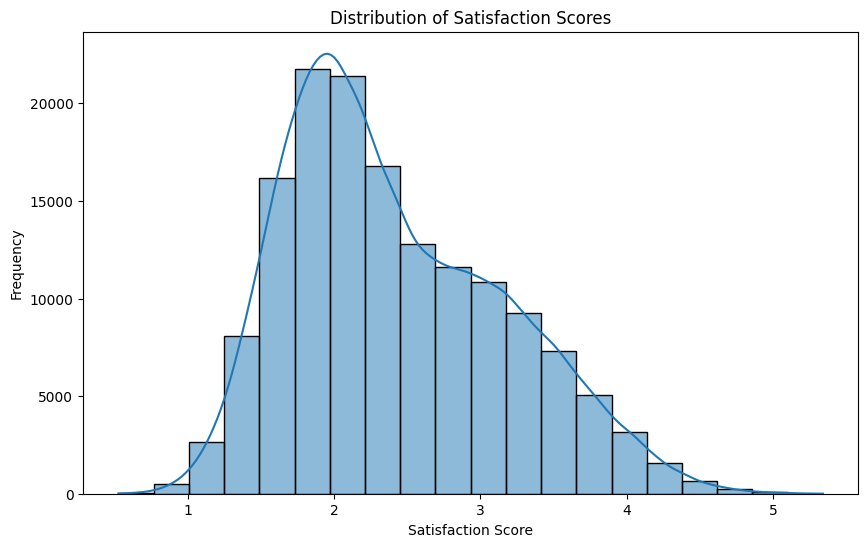

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Satisfaction Score'], bins=20, kde=True)
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.show()


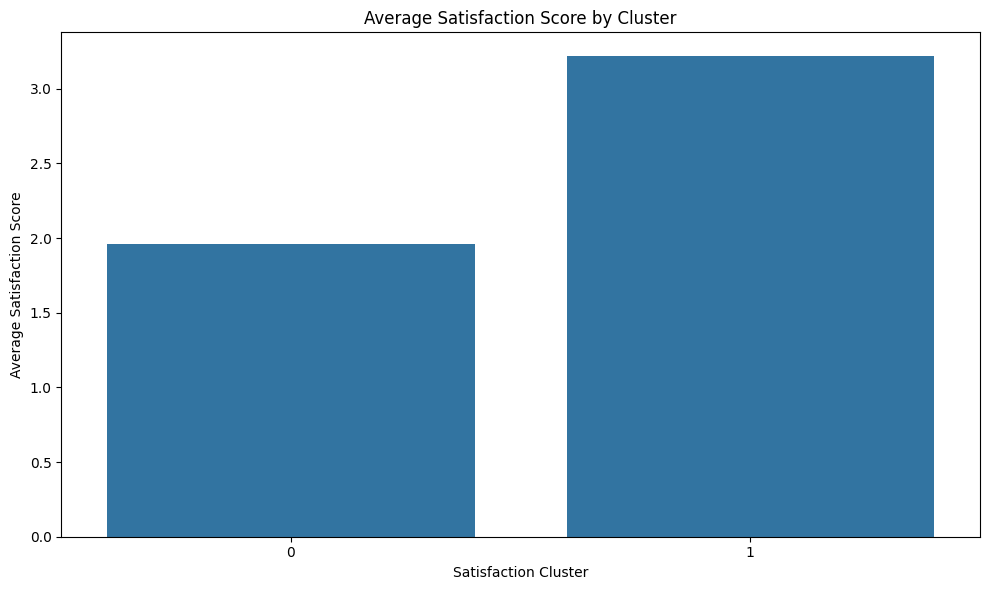

In [14]:
cluster_aggregates = df_cleaned.groupby('Satisfaction Cluster')['Satisfaction Score'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Satisfaction Cluster', y='Satisfaction Score', data=cluster_aggregates)
plt.title('Average Satisfaction Score by Cluster')
plt.xlabel('Satisfaction Cluster')
plt.ylabel('Average Satisfaction Score')
plt.tight_layout()
plt.show()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

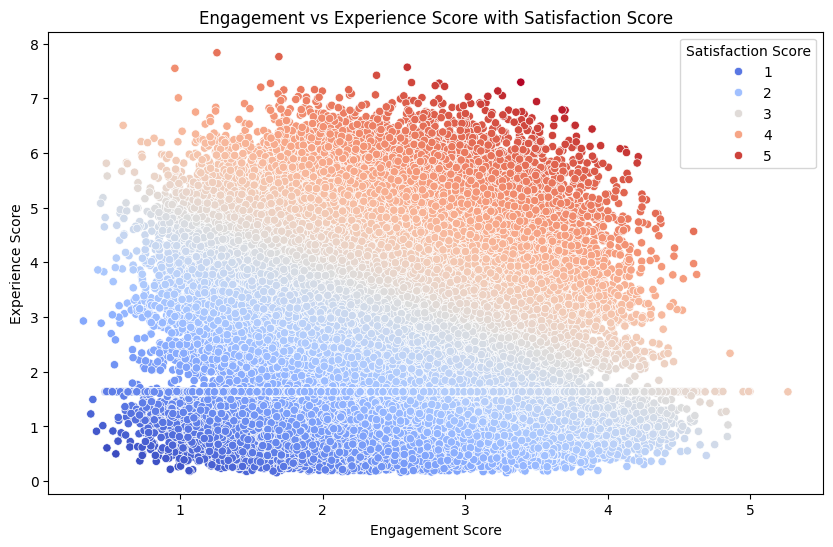

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Engagement Score', y='Experience Score', hue='Satisfaction Score', palette='coolwarm', data=df_cleaned)
plt.title('Engagement vs Experience Score with Satisfaction Score')
plt.xlabel('Engagement Score')
plt.ylabel('Experience Score')
plt.colorbar(label='Satisfaction Score')
plt.show()
